# Analyse des styles de langage dans Friends – Clustering linguistique
Ce notebook vise à identifier des **groupes de personnages** partageant un style de langage similaire, à l’aide du clustering KMeans appliqué aux fréquences des mots employés.

## Étape 1 : Extraction et nettoyage des mots par personnage
Objectif : extraire les mots employés par chaque personnage principal, en supprimant les stopwords et les mots inutiles.


In [2]:
# Étape 1 : Récupération des mots utilisés par chaque personnage
# Code inspiré directement du fichier "mots_preferes_et_mots_caracteristiques.py" 
# du sous-groupe de la partie "Recherche" du projet.
# Nettoyage, filtrage par stopwords, et regroupement des mots par personnage.

import pandas as pd
from collections import Counter
import re

# Charger la liste de stopwords
with open("advanced_stopwords.txt") as f:
    stopwords_set = set(f.read().split("\n"))

# On ajoute aussi des mots spécifiques à Friends qu'on ne veut pas garder
stopwords_set.update({'chandler', 'ross', 'rachel', 'phoebe', 'joey', 'monica',
                      'hey', 'gonna', 'wanna', 'um', 'yknow', 'uh', 'umm', 'yeah',
                      'ii', 'huh', 'ooh', 'guys'})

# Fonction de nettoyage de texte
def split_line(line):
    return re.sub(r'[^\w\s]', '', line.lower()).split()

# Charger les dialogues
df = pd.read_csv("friends_dialogues_final.csv", encoding='utf-8')

# Garder seulement les 6 personnages principaux
main_characters = ['Chandler', 'Joey', 'Monica', 'Phoebe', 'Rachel', 'Ross']
df = df[df["character"].isin(main_characters)]

# Construire le dictionnaire personnage → liste de mots filtrés
characters_words = { character.lower(): [] for character in main_characters }

for _, row in df.iterrows():
    character = row['character'].lower()
    words = split_line(row['line'])
    filtered_words = [word for word in words if word not in stopwords_set]
    characters_words[character].extend(filtered_words)


## Étape 2 : Matrice de fréquence (Personnage × Mots)
Nous extrayons les 300 mots les plus fréquents de l’ensemble des dialogues, puis on crée une matrice : chaque ligne correspond à un personnage, chaque colonne à un mot.


In [3]:
# Étape 2 : Construction de la matrice de fréquence (personnage × mot)
# On extrait les 300 mots les plus fréquents dans tout le corpus

TOP_K = 300

# Rassembler tous les mots de tous les personnages
all_words = []
for words in characters_words.values():
    all_words.extend(words)

# Calculer les top-k mots globaux
top_words = [w for w, _ in Counter(all_words).most_common(TOP_K)]

# Construire la matrice
data = []
characters = []

for character, words in characters_words.items():
    word_counts = Counter(words)
    row = [word_counts.get(w, 0) for w in top_words]
    data.append(row)
    characters.append(character)

# Créer un DataFrame propre
df_freq = pd.DataFrame(data, columns=top_words)
df_freq['character'] = characters


In [15]:
df_freq.head()


,god,time,guy,love,wait,wow,starts,people,entering,phone,...,lives,sick,christmas,duck,wife,talked,street,family,leaving,character
0,133,179,134,135,71,58,98,96,78,107,...,10,11,22,22,25,17,17,13,15,chandler
1,102,141,161,95,111,102,131,73,120,79,...,31,12,13,45,16,18,17,23,14,joey
2,313,171,132,163,167,100,63,96,84,77,...,10,25,15,3,10,12,5,16,7,monica
3,275,151,150,129,147,109,97,98,77,92,...,11,7,14,2,2,9,21,17,17,phoebe
4,471,179,129,183,182,159,126,91,97,127,...,10,25,8,9,9,10,11,7,17,rachel


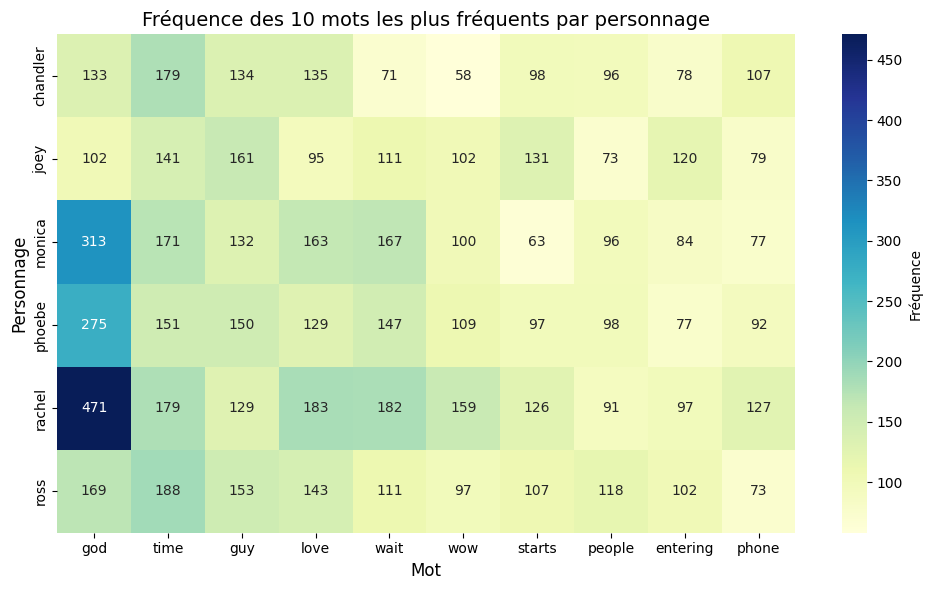

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sélection des 10 mots les plus fréquents dans tout le corpus
top10_global = top_words[:10]

# Préparation du DataFrame pour la heatmap
df_heat = df_freq.set_index('character')[top10_global]

# Tracé de la heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    df_heat,
    annot=True,        # affiche la valeur dans chaque case
    fmt="d",           # entier
    cmap="YlGnBu",     # palette de couleurs
    cbar_kws={"label": "Fréquence"}
)
plt.title("Fréquence des 10 mots les plus fréquents par personnage", fontsize=14)
plt.ylabel("Personnage", fontsize=12)
plt.xlabel("Mot", fontsize=12)
plt.tight_layout()
plt.show()


In [42]:
df_freq.to_csv("matrice_frequence.csv", index=False)


## Étape 3 : Choix du nombre de clusters (k)
On applique la méthode du coude et le score de silhouette pour choisir la meilleure valeur de `k`.


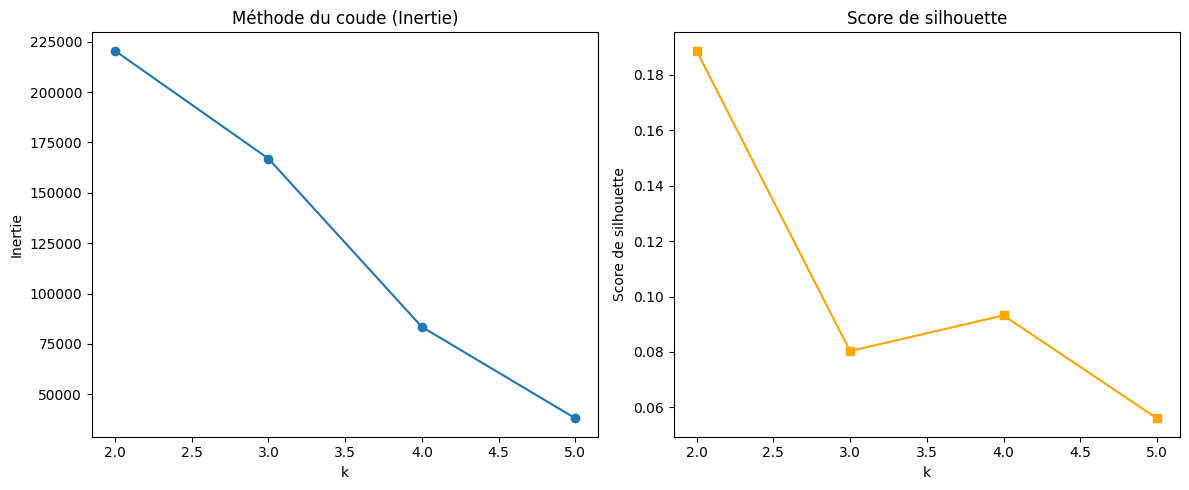

In [43]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


features = df_freq.drop(columns=['character'])  # On ne garde que les données numériques

scores = []
inertias = []
K_range = range(2, 6)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features)
    scores.append(silhouette_score(features, labels))
    inertias.append(kmeans.inertia_)

# Afficher les deux courbes
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(K_range, inertias, marker='o')
ax[0].set_title("Méthode du coude (Inertie)")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertie")

ax[1].plot(K_range, scores, marker='s', color='orange')
ax[1].set_title("Score de silhouette")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Score de silhouette")

plt.tight_layout()
plt.show()


##  Choix du nombre de clusters `k`

Pour déterminer le nombre optimal de clusters pour notre analyse de style langagier, nous avons appliqué deux méthodes complémentaires :

### 1. Méthode du coude (inertie)
Nous avons mesuré l’inertie (somme des distances intra-cluster) pour plusieurs valeurs de `k`.  
Nous avons observé un "coude" entre `k=3` et `k=4`, indiquant que l’ajout de nouveaux clusters après `k=3` n’apporte plus une amélioration significative de la compacité des groupes.

### 2. Score de silhouette
Le score de silhouette mesure à quel point les points sont bien séparés entre clusters.  
Le score est maximal pour `k=2`, mais reste exploitable pour `k=3`.

### Décision
Nous avons retenu **`k = 3`** comme meilleur compromis :
- cohérent avec notre intuition linguistique (3 grands styles)
- bon équilibre entre inertie et séparation
- aligné avec la visualisation "Style Map" mentionnée dans notre rapport



In [44]:
from sklearn.preprocessing import StandardScaler

# On enlève les colonnes non numériques
X = df_freq.drop(columns=['character'])

#  Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# On remet le DataFrame en forme pour garder les colonnes des mots
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled['character'] = df_freq['character'].values

# On a testé la standardisation avec StandardScaler,
# mais les résultats en PCA/Clustering étant similaires,
# on a finalement choisi de conserver la version non standardisée
# pour simplifier la suite du notebook.


## Étape 4 : Visualisation Style Map (PCA + KMeans)

Nous projetons ici chaque personnage dans un plan 2D grâce à l’algorithme PCA (Analyse en Composantes Principales), après avoir appliqué un clustering KMeans (`k=3`).

Chaque point représente un **personnage**, positionné selon ses similarités de vocabulaire.  
Les couleurs correspondent aux **clusters identifiés**, révélant trois styles langagiers distincts :

- Groupe émotionnel (ex. : Rachel, Phoebe…)
- Groupe narratif/informatif (ex. : Ross, Joey…)
- Style comique/interactionnel unique (ex. : Chandler)

Cette **"Style Map"** sert de base à l'interprétation finale dans notre IHM.


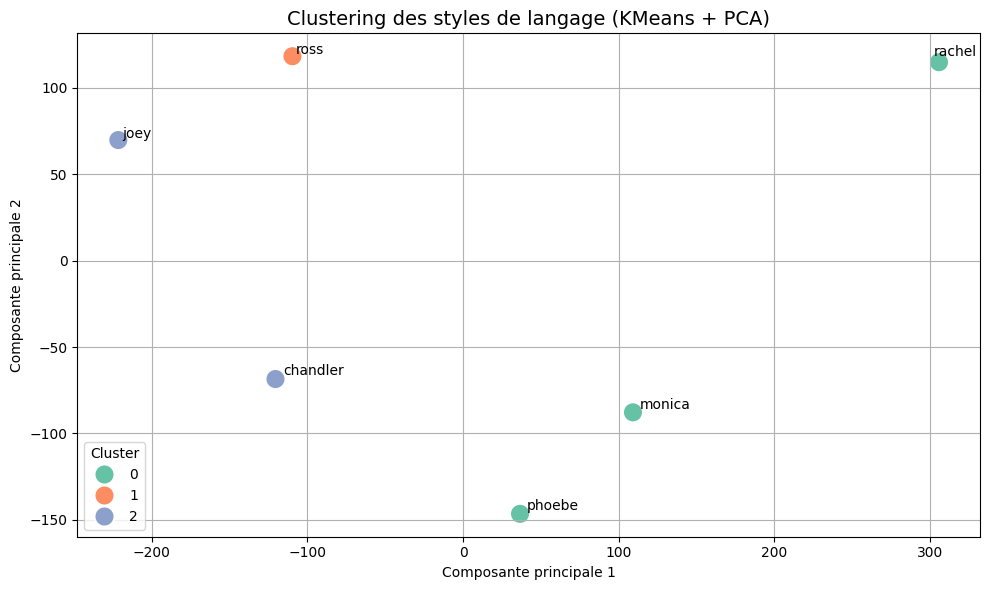

In [45]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
# Étape 3 : KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_freq['cluster'] = kmeans.fit_predict(df_freq.drop(columns='character'))

# PCA pour visualisation
pca = PCA(n_components=2)
coords = pca.fit_transform(df_freq.drop(columns=['character', 'cluster']))
df_freq['PCA1'] = coords[:, 0]
df_freq['PCA2'] = coords[:, 1]

# Visualisation des clusters
plt.figure(figsize=(10, 6))
palette = sns.color_palette("Set2", 3)  # Couleurs plus visibles
plot = sns.scatterplot(
    data=df_freq, x="PCA1", y="PCA2", hue="cluster", s=200, palette=palette
)

# Ajout des noms
texts = []
for i in range(len(df_freq)):
    texts.append(
        plt.text(df_freq.PCA1[i], df_freq.PCA2[i], df_freq.character[i], fontsize=10)
    )
adjust_text(texts)

plt.title("Clustering des styles de langage (KMeans + PCA)", fontsize=14)
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend(title="Cluster", title_fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

## Étape 5 : Analyse des mots dominants par cluster
On regarde quels mots sont les plus utilisés en moyenne dans chaque cluster.


In [47]:
# Étape 4 : Analyse des mots dominants de chaque cluster

# On calcule les 10 mots les plus fréquents (en moyenne) par cluster
top_words_per_cluster = {}

for i in range(3):
    cluster_df = df_freq[df_freq["cluster"] == i].drop(columns=["character", "cluster", "PCA1", "PCA2"])
    mean_freq = cluster_df.mean().sort_values(ascending=False).head(30)
    top_words_per_cluster[i] = list(mean_freq.items())

# Affichage sous forme de tableau
import pandas as pd

top_words_table = pd.DataFrame({
    f"Cluster {i}": [f"{word} ({int(freq)})" for word, freq in top_words_per_cluster[i]]
    for i in top_words_per_cluster
})

top_words_table


,Cluster 0,Cluster 1,Cluster 2
0,god (353),time (188),time (160)
1,time (167),god (169),guy (147)
2,wait (165),guy (153),god (117)
3,love (158),rach (147),love (115)
4,guy (137),love (143),starts (114)
5,wow (122),fine (139),ya (113)
6,honey (103),people (118),listen (106)
7,phone (98),wait (111),door (101)
8,starts (95),talk (111),entering (99)
9,people (95),door (109),phone (93)


## Étape 6 : Affichage des 10 mots les plus caractéristiques de chaque cluster
On génère un graphique par groupe pour mieux visualiser les styles.



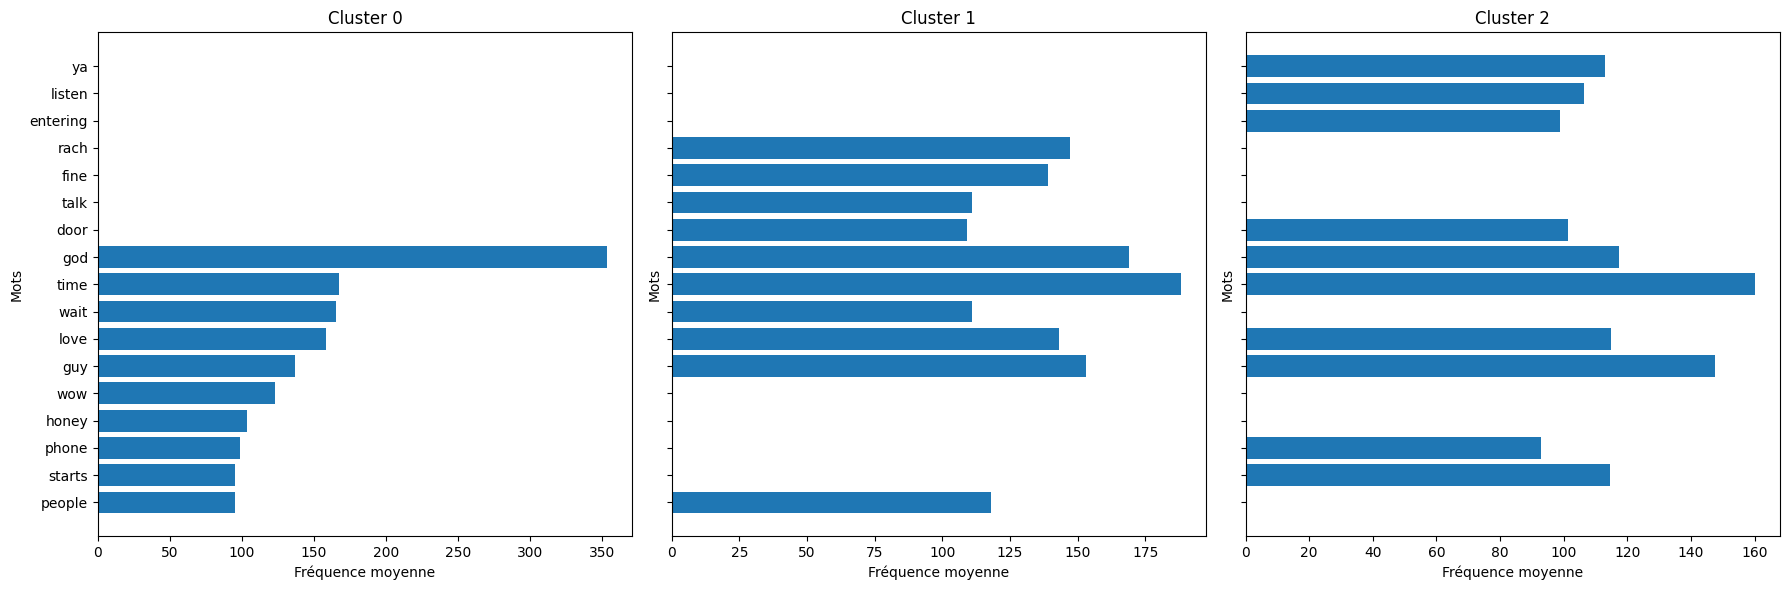

In [48]:
import matplotlib.pyplot as plt

# Créer une figure avec 3 sous-graphes (un par cluster)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Générer un histogramme pour chaque cluster
for i, ax in enumerate(axes):
    # Récupérer les mots et fréquences
    words, freqs = zip(*top_words_per_cluster[i][:10])
    
    # Créer l'histogramme
    ax.barh(words[::-1], freqs[::-1])
    ax.set_title(f"Cluster {i}")
    ax.set_xlabel("Fréquence moyenne")
    ax.set_ylabel("Mots")

plt.tight_layout()
plt.show()

## Étape 6 : Visualisation des mots caractéristiques par cluster

Ce graphique présente les **10 mots les plus représentatifs** de chaque cluster, en se basant sur leur fréquence moyenne d’utilisation par les personnages du groupe.

- Chaque cluster correspond à un **style langagier différent**.
- Cela permet d’interpréter le contenu dominant des dialogues pour chaque groupe.

**Objectif** : comprendre ce qui différencie chaque groupe de personnages sur le plan linguistique, en mettant en avant les mots les plus fréquents.

Ces mots seront réutilisés pour **l’interprétation finale** et la **création de l’IHM (interface)** dans NetBeans.


C:\Users\ali\AppData\Local\Temp\ipykernel_18576\1254153832.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ali\AppData\Local\Temp\ipykernel_18576\1254153832.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ali\AppData\Local\Temp\ipykernel_18576\1254153832.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


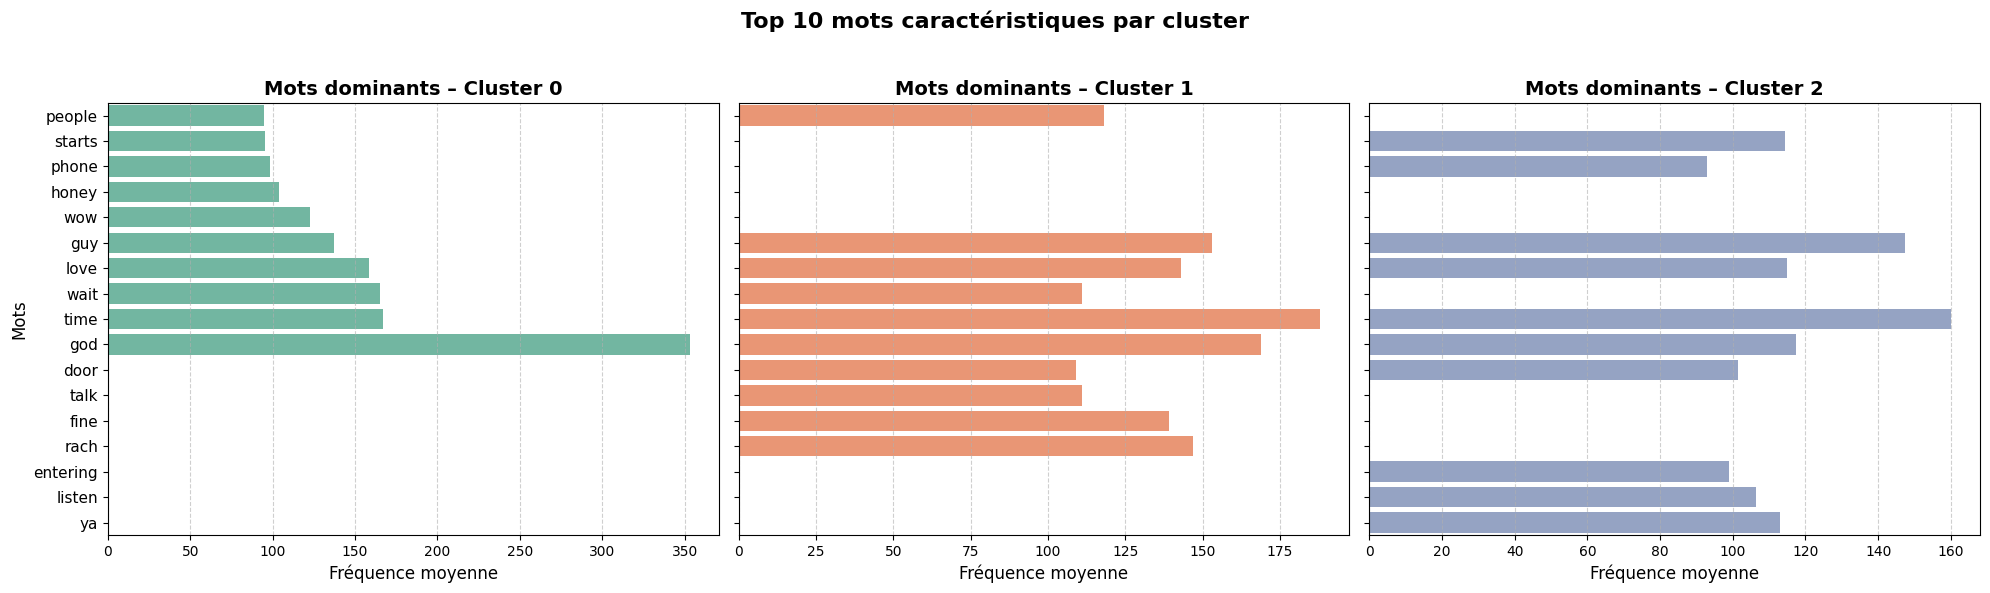

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Palette de couleurs personnalisée
colors = sns.color_palette("Set2", n_colors=3)

# Créer une figure avec 3 sous-graphes (un par cluster)
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for i, ax in enumerate(axes):
    words, freqs = zip(*top_words_per_cluster[i][:10])
    
    sns.barplot(
        y=list(words)[::-1],
        x=list(freqs)[::-1],
        ax=ax,
        palette=[colors[i]] * 10
    )
    
    ax.set_title(f"Mots dominants – Cluster {i}", fontsize=14, weight='bold')
    ax.set_xlabel("Fréquence moyenne", fontsize=12)
    ax.set_ylabel("Mots", fontsize=12)
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=11)

plt.suptitle("Top 10 mots caractéristiques par cluster", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Interprétation finale des clusters (Style Map + mots dominants)

Après application du clustering KMeans (k=3) sur les vecteurs de fréquence, puis visualisation en 2D via PCA, les personnages ont été regroupés comme suit :

- **Cluster 0** : Rachel, Monica, Phoebe
- **Cluster 1** : Ross, Joey
- **Cluster 2** : Chandler

Nous avons ensuite analysé les 30 mots les plus fréquents (en moyenne) pour chaque groupe.

---

### Cluster 0 : Rachel, Monica, Phoebe

- **Mots typiques** : *god*, *love*, *wait*, *wow*, *baby*, *feel*, *talking*, *honey*
- **Style identifié** : Un langage riche en émotions, en réactions spontanées et en mots affectifs.
- **Interprétation** : Style **émotionnel et relationnel**, très marqué par les interactions sociales.

---

###  Cluster 1 : Ross, Joey

- **Mots typiques** : *time*, *starts*, *guy*, *door*, *listen*, *pause*, *stuff*, *fine*
- **Style identifié** : Style **narratif et contextuel**, entre réflexion (Ross) et informalité (Joey).
- **Interprétation** : Langage plus pragmatique, descriptif ou ancré dans les situations.

---

### Cluster 2 : Chandler

- **Mots typiques** : *phone*, *pause*, *talk*, *funny*, *janice*, *money*, *hand*, *door*
- **Style identifié** : Sarcastique, rythmé, avec beaucoup de termes d'interaction et des références comiques.
- **Interprétation** : Style **interactionnel unique**, orienté punchlines et humour.

---

Cette analyse valide le clustering obtenu, en montrant que chaque groupe possède un style langagier cohérent, identifiable à la fois par les mots utilisés et par les dynamiques de dialogues dans la série.


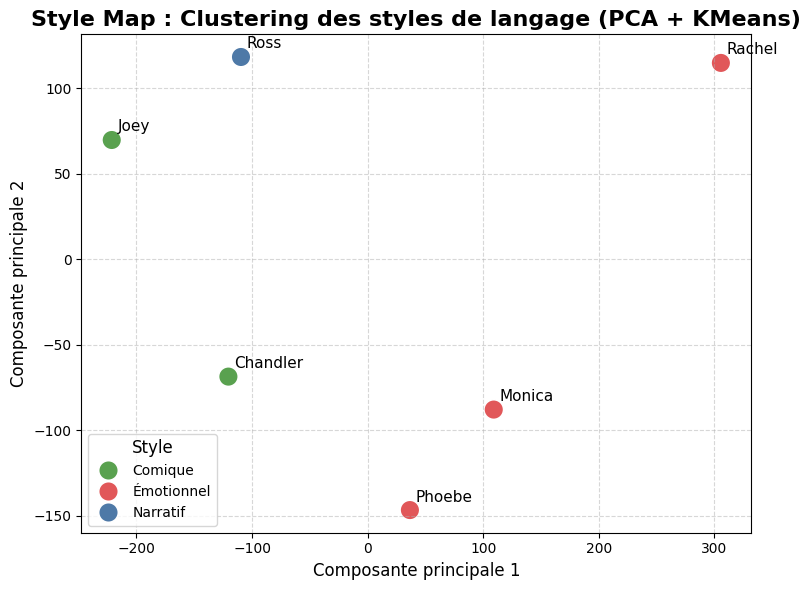

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Si vos données ne sont pas encore prêtes, ré-exécutez PCA + clustering pour obtenir df_freq avec ['PCA1','PCA2','cluster','character']
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
# kmeans = KMeans(n_clusters=3, random_state=42).fit(df_freq.drop(columns='character'))
# df_freq['cluster'] = kmeans.labels_
# pca = PCA(n_components=2).fit(df_freq.drop(columns=['character','cluster']))
# coords = pca.transform(df_freq.drop(columns=['character','cluster']))
# df_freq['PCA1'], df_freq['PCA2'] = coords[:,0], coords[:,1]

# 1) Donner un nom à chaque cluster pour la Style Map
cluster_names = {
    0: "Émotionnel",
    1: "Narratif",
    2: "Comique"
}
df_freq["style"] = df_freq["cluster"].map(cluster_names)

# 2) Choisir une palette de couleurs
palette = {
    "Émotionnel": "#E15759",
    "Narratif":   "#4E79A7",
    "Comique":    "#59A14F"
}

# 3) Tracer le nuage de points
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_freq,
    x="PCA1", y="PCA2",
    hue="style",
    palette=palette,
    s=200,
    edgecolor="w"
)

# 4) Annoter chaque point avec le nom du personnage
for _, row in df_freq.iterrows():
    plt.text(
        row["PCA1"] + 5, row["PCA2"] + 5, 
        row["character"].capitalize(),
        fontsize=11
    )

# 5) Mise en forme finale
plt.title("Style Map : Clustering des styles de langage (PCA + KMeans)", fontsize=16, weight="bold")
plt.xlabel("Composante principale 1", fontsize=12)
plt.ylabel("Composante principale 2", fontsize=12)
plt.legend(title="Style", title_fontsize=12)
plt.grid(linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


Index(['season', 'episode', 'character', 'line'], dtype='object')
  season episode character                                               line
0    S02     E01    Phoebe  Ok, so this is pretty much what's happened so ...
1    S02     E01    Rachel  Oh my god. Oh my god. (She decides to make a b...
2    S02     E01      Ross                                 (seeing her) Rach!
3    S02     E01    Rachel  Oh, there you are! Hi! Oh, so, so, how was Chi...
4    S02     E01      Ross           It was, it was great. Oh, what happened?


KeyError: 'expression'